# 06. PyTorch Custom Datasets

In [109]:
import torch
from torch import nn
import requests
import zipfile
from pathlib import Path
import os
import random 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import datasets


In [110]:
#setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [111]:
!nvidia-smi


Fri Sep 27 19:00:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8              3W /   95W |     166MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data 

Our dataset is a subset of the Food101 dataset.


In [112]:
# Setup path to a data folder
from pathlib import Path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else: 
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


## 2. data preparation and data exploration

In [113]:
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [114]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [115]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths 
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem` 
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [116]:
image_path

WindowsPath('data/pizza_steak_sushi')

Random image path: data\pizza_steak_sushi\test\sushi\1742201.jpg
Image class: sushi
Image height: 512
Image width: 512


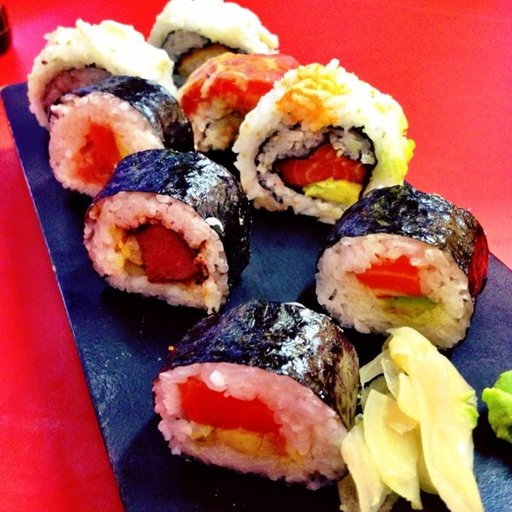

In [117]:
# Set seed
# random.seed(42)
from PIL import Image
# 1. Get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata 
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

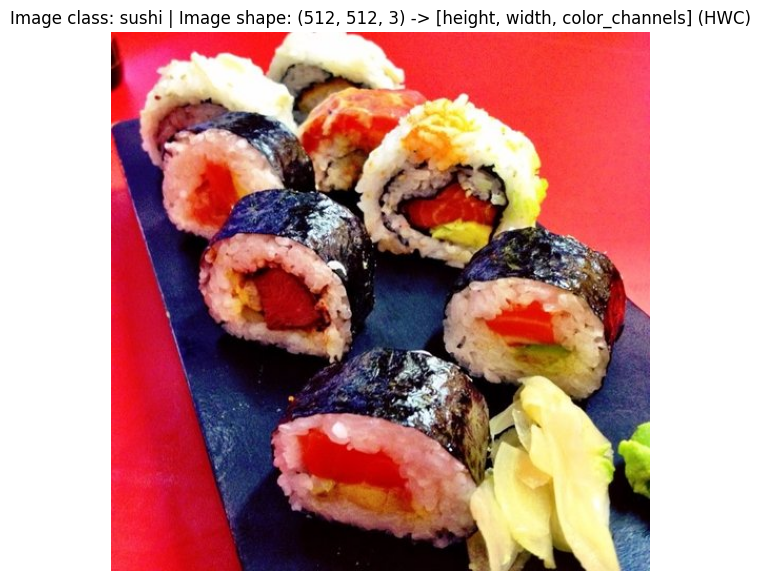

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

In [119]:
img_as_array

array([[[252,  19,  15],
        [250,  21,  16],
        [249,  26,  19],
        ...,
        [251,  56,  96],
        [249,  54,  98],
        [255,  61, 105]],

       [[251,  22,  19],
        [250,  22,  19],
        [245,  26,  20],
        ...,
        [252,  57,  97],
        [249,  54,  96],
        [255,  61, 105]],

       [[246,  22,  20],
        [243,  24,  20],
        [239,  24,  19],
        ...,
        [253,  58,  98],
        [249,  54,  96],
        [255,  61, 103]],

       ...,

       [[253,  47,  70],
        [255,  51,  74],
        [255,  49,  72],
        ...,
        [110, 151, 183],
        [108, 149, 179],
        [ 91, 132, 160]],

       [[245,  39,  62],
        [244,  38,  61],
        [248,  42,  65],
        ...,
        [103, 144, 176],
        [100, 141, 169],
        [113, 157, 182]],

       [[248,  42,  65],
        [243,  37,  60],
        [251,  45,  68],
        ...,
        [126, 167, 197],
        [ 99, 143, 170],
        [114, 158, 183]]

## 3. Transforming data 

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.


### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation

In [120]:
# Write a transform for image
data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() 
])

In [121]:
data_transform(img).shape

torch.Size([3, 64, 64])

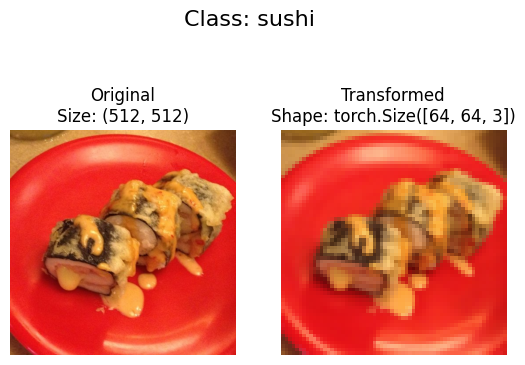

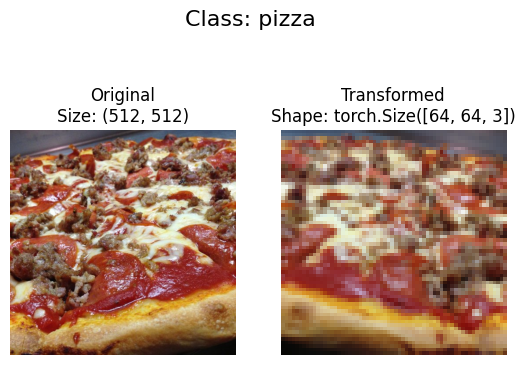

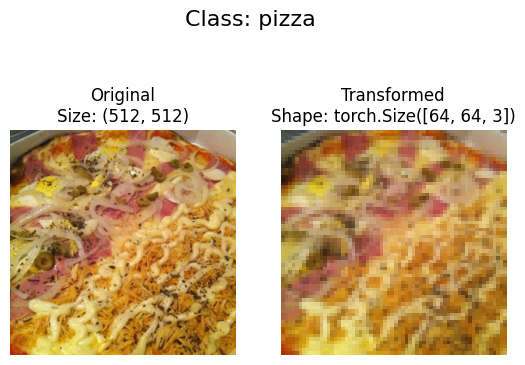

In [122]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms 
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [123]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target 

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [124]:
train_dir, test_dir


(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [125]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [126]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [127]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [128]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [129]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

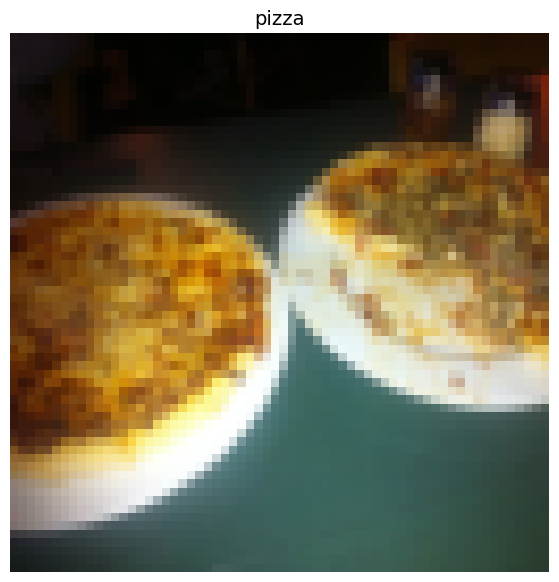

In [130]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`'s 

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [131]:
os.cpu_count()

16

In [132]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x182677fcb00>,
 <torch.utils.data.dataloader.DataLoader at 0x1826786d5e0>)

In [133]:
len(train_dataloader), len(test_dataloader)


(225, 75)

In [134]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues 

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset 


In [135]:
from typing import Tuple, Dict, List

In [136]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [137]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory 
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [138]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [139]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [140]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use 
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [141]:
# 1. Write a coustome dataset class
from torch.utils.data import Dataset
from pathlib import Path
import pathlib
#2. subclass torch.utils data.Dataset
class ImageFolderCustom(Dataset):
    #3. Initialize the class
    def __init__(self, targ_dir: str, transform=None):
        #4.create class attributes
        # get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # setup transformer
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    # 5. create a function to load images
    def load_images(self, index: int) -> Image.Image:
        "open an iameg via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 6. Overwrite __len__()
    def __len__(self) -> int:
        "return total number of samples."
        return len(self.paths)
    
    #7. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data , data and lebel (X,y)"
        img = self.load_images(index)
        class_name =self.paths[index].parent.name #except path in format :data_folder
        class_idx = self.class_to_idx[class_name]

        #transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx #return untransformed image and lable


In [142]:
img, label = train_data[0]
img, label

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [143]:
# create a transform 
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
]) 
test_tranforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])


In [144]:
# test out Image folder custom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                     transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform=test_tranforms)

In [145]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x18267a259a0>,
 <__main__.ImageFolderCustom at 0x18267472f90>)

In [146]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [147]:
len(test_data), len(test_data_custom)

(75, 75)

In [148]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [149]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matploltib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [150]:
# create a function to take in a dataset 
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed :int = None):
    # adjust display if n is to high
    if n>10:
        n=10 
        diplay_shape = False
        print(f"Displaying {n} random images...")
    # 1. random seed
    if seed:
        random.seed(seed)

    # get randpm sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    #set up plot 
    plt.figure(figsize=(16,8))

    # loop through random indexes and display images and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # adjust tensor dimension for plotting 
        targ_image_adjust = targ_image.permute(1, 2, 0) # change shape from (C, H, W) -> (H, W, C)

        # plot image
        plt.subplot(n, 1, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {targ_image_adjust.shape}"
            plt.title(title)


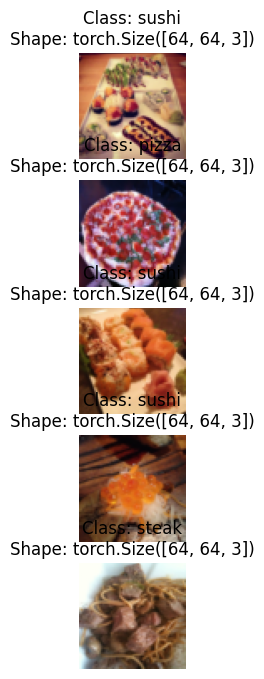

In [151]:
# Display random images from the ImageFolder Create Dastset
display_random_images(train_data,
                      n=5,
                      classes= class_names,
                      seed = None)


### 5.4 Turn custom loaded images into `DataLoader`'s





In [152]:
from torch.utils.data import DataLoader
BATCH_SIZE=1
#NUM_WORKERS= os.cpu_count()
NUM_WORKERS= 0
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1826738c3e0>,
 <torch.utils.data.dataloader.DataLoader at 0x1826792b440>)

In [153]:
# Get image and label from custom datloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape


(torch.Size([1, 3, 64, 64]), torch.Size([1]))

Setting `NUM_WORKERS = 0` in the PyTorch `DataLoader` makes it run in **single-threaded** mode. This means that data loading happens in the **main process** without spawning any additional worker processes. Here's what happens:

### How `NUM_WORKERS = 0` Affects the Output:
1. **Single-threaded Operation**:
   - The data loading is done in the same thread as the training process, meaning there's no parallelization for fetching batches.
   
2. **No Multiprocessing**:
   - Normally, using multiple workers allows data loading to happen in parallel to model training, which can speed up training. When you set `NUM_WORKERS = 0`, it prevents multiprocessing entirely, meaning no parallel fetching.

3. **Simplified Data Loading**:
   - With no multiprocessing, issues related to forking processes (common in Windows), shared memory, or process management (like worker exits or crashes) are avoided. This makes debugging easier.

4. **Performance Impact**:
   - On the downside, performance might be slower since the training and data loading processes are happening sequentially in the same thread. However, if data loading is not a bottleneck (e.g., your dataset is small or already in memory), this may not be an issue.

### When `NUM_WORKERS = 0` is Useful:
- **Debugging**: It's easier to debug data loading issues because multiprocessing often hides or complicates error messages.
- **Small Datasets**: For small datasets where the overhead of creating worker processes is unnecessary.
- **Limited Resources**: If your system has limited memory or CPU cores, using fewer or no workers can help reduce resource usage.

Would you like to explore optimizing the number of workers based on your system?

## 6. Other forms of transforms (data augmentation)

In [154]:
# Let's look at trivailaugment - https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide 
from torchvision import transforms

train_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()
])

In [155]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [156]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

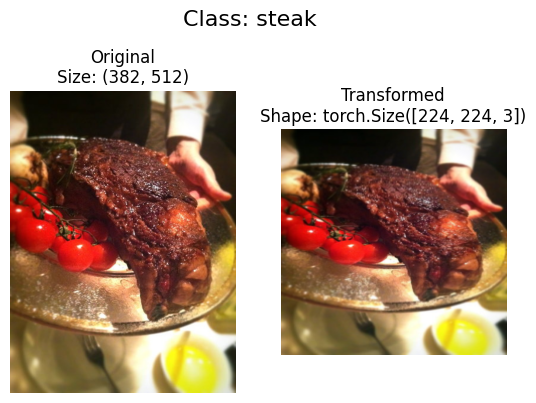

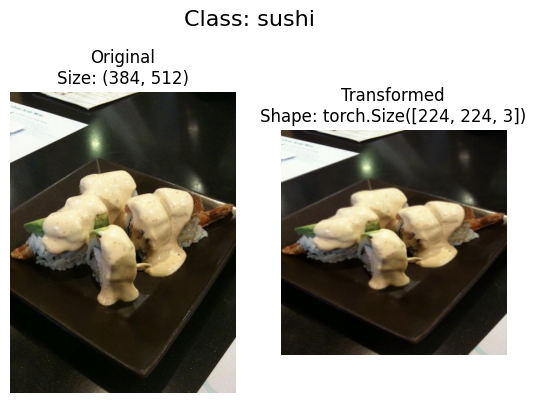

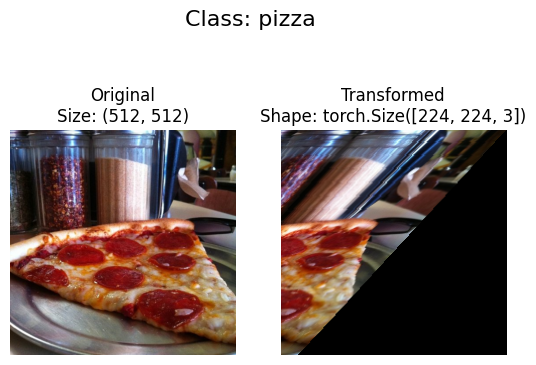

In [157]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation 

### 7.1 Creating transforms and loading data for Model 0

In [158]:
# Create simple transform
simple_transform = transforms.Compose([
                                       transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()
])

In [159]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [160]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, 
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html

In [161]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10, 
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [162]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [163]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9127e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0238e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7226e-03,  8.3785e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2131e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [164]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [165]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
  
  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader) 
  return train_loss, train_acc 

In [166]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader): 
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [167]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5, 
          device=device):
  
  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model 0

In [168]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer() 

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:11<00:47, 11.83s/it]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011


 40%|████      | 2/5 [00:23<00:34, 11.50s/it]

Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417


 60%|██████    | 3/5 [00:34<00:22, 11.32s/it]

Epoch: 2 | Train loss: 1.0868 | Train acc: 0.4883 | Test loss: 1.0807 | Test acc: 0.4924


 80%|████████  | 4/5 [00:45<00:11, 11.20s/it]

Epoch: 3 | Train loss: 1.0842 | Train acc: 0.4023 | Test loss: 1.0609 | Test acc: 0.5833


100%|██████████| 5/5 [00:56<00:00, 11.24s/it]

Epoch: 4 | Train loss: 1.0663 | Train acc: 0.4141 | Test loss: 1.0655 | Test acc: 0.5644
Total training time: 56.220 seconds


In [169]:
model_0_results

{'train_loss': [1.1063183844089508,
  1.0998327136039734,
  1.0868093222379684,
  1.0841942429542542,
  1.0662896633148193],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.4140625],
 'test_loss': [1.0983396371205647,
  1.0696712334950764,
  1.0806643565495808,
  1.060887058575948,
  1.0654944976170857],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}